In [1]:
import torch.nn.functional as Fun
import torch
from torch import nn
import torchvision.transforms as transforms
import numpy as np
import random
random_seed = 100
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from torch.utils.data import (
    Dataset,
    DataLoader,
)
"""Здесь обучается модель которая различает только пиццы с ананасами и грушами 
+ некоторые другие на которых ошибалась лучшая модель"""

In [2]:
ctr = pd.read_csv('train.csv')
cte = pd.read_csv('labels.csv')
ctr = ctr[(ctr['label']==5) | (ctr['label']==6) | (ctr['label']==27) | (ctr['label']==28) | (ctr['label']==29)
         | (ctr['label']==33) | (ctr['label']==14) | (ctr['label']==9) | (ctr['label']==13)]
cte = cte[(cte['label']==5) | (cte['label']==6) | (cte['label']==27) | (cte['label']==28) | (cte['label']==29)
         | (cte['label']==33) | (cte['label']==14) | (cte['label']==9) | (cte['label']==13)]
ctr.to_csv('ananastrain.csv', index=False, header=True)
cte.to_csv('ananaslabels.csv', index=False, header=True)

In [3]:
class PizzaDataset(Dataset):
    def __init__(self, csv_file="train.csv", root="train_196", transform=None, target_transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img_path = os.path.join(self.root, self.labels.iloc[index, 1])
        img_path = os.path.join(self.root, img_path)
        image = Image.open(img_path)
        label = torch.tensor(int(self.labels.iloc[index, 2]))

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [4]:
training_data = PizzaDataset(
    csv_file="ananastrain.csv",
    root="train_196",
    transform=transforms.Compose([transforms.RandomChoice([transforms.RandomVerticalFlip(), 
                                                           transforms.RandomHorizontalFlip(), 
                                                           transforms.RandomRotation(45)]), 
                                  transforms.ToTensor()]),
    target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
)

test_data = PizzaDataset(
    csv_file="ananaslabels.csv",
    root="test_196",
    transform=transforms.ToTensor(),
    target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
)

In [5]:
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False)

C:\Users\Артур\AppData\Local\Temp\ipykernel_9768\3608014143.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
C:\Users\Артур\AppData\Local\Temp\ipykernel_9768\79872142.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
C:\Users\Артур\AppData\Local\Temp\ipykernel_976

Original Images


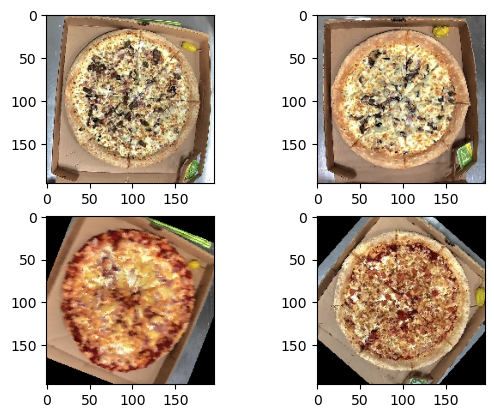

CutMix Images


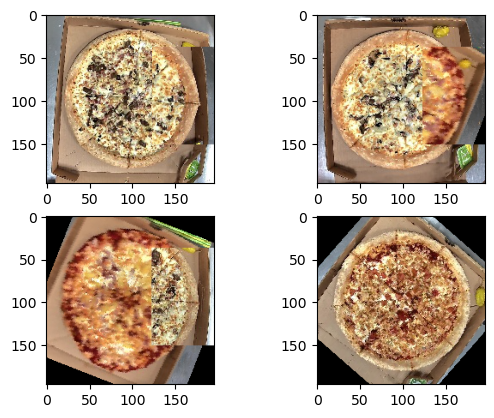

CutMix Images


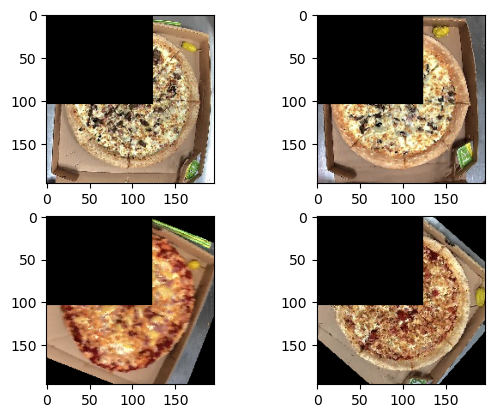

In [6]:
def rand_bbox(size, lamb):
    """ Generate random bounding box 
    Args:
        - size: [width, breadth] of the bounding box
        - lamb: (lambda) cut ratio parameter, sampled from Beta distribution
    Returns:
        - Bounding box
    """
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lamb)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def generate_cutmix_image(image_batch, image_batch_labels, beta):
    """ Generate a CutMix augmented image from a batch 
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutMix image batch, updated labels
    """
    # generate mixed sample
    lam = np.random.beta(beta, beta)
    #print(lam)
    rand_index = np.random.permutation(len(image_batch))
    target_a = image_batch_labels
    target_b = image_batch_labels[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0][0].shape, lam)
    image_batch_updated = image_batch.numpy().copy()
    image_batch_updated[:, :, bbx1:bbx2, bby1:bby2] = image_batch[rand_index, :, bbx1:bbx2, bby1:bby2]
    
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.shape[3] * image_batch.shape[2]))
    label = target_a * lam + target_b * (1. - lam)
    
    return torch.Tensor(image_batch_updated),label

def generate_cutout_image(image_batch, image_batch_labels, beta):
    """ Generate a CutOut augmented image from a batch 
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutOut image batch, labels
    """
    # generate cutout sample
    lam = np.random.beta(beta, beta)
    #print(lam)
    target_a = image_batch_labels
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0][0].shape, lam)
    image_batch_updated = image_batch.numpy().copy()
    zero_image = np.zeros(image_batch_updated[0].shape)
    image_batch_updated[:, :, bbx1:bbx2, bby1:bby2] = zero_image[:, bbx1:bbx2, bby1:bby2]
    
    return torch.Tensor(image_batch_updated), image_batch_labels

# Generate CutMix image
# Let's use the first image of the batch as the input image to be augmented
for x, y in train_dataloader:
    image_batch = x
    image_batch_labels = y
    break
input_image = image_batch[0]
image_batch_updated, image_batch_labels_updated = generate_cutmix_image(image_batch[:4], image_batch_labels[:4], 1.0)

# Show original images
print("Original Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        #plt.imshow(image_batch[2*i+j].numpy())
        plt.imshow(np.moveaxis(image_batch[2*i+j].numpy(),0,-1))
plt.show()


# Show CutMix images
print("CutMix Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        #plt.imshow(image_batch_updated[2*i+j])
        plt.imshow(np.moveaxis(image_batch_updated[2*i+j].numpy(),0,-1))
plt.show()
image_batch_updated, image_batch_labels_updated = generate_cutout_image(image_batch[:4], image_batch_labels[:4], 1.0)
# Show CutOut images
print("CutMix Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        #plt.imshow(image_batch_updated[2*i+j])
        plt.imshow(np.moveaxis(image_batch_updated[2*i+j].numpy(),0,-1))
plt.show()

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
torch.cuda.empty_cache()

Using cuda device


In [8]:
from torchvision.models import regnet_y_3_2gf, RegNet_Y_3_2GF_Weights

weights = RegNet_Y_3_2GF_Weights.DEFAULT
model = regnet_y_3_2gf(weights=weights)#preprocess is also here
model.to(device)
model.train()

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 72, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(72, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
            

In [9]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99))
from tqdm import tqdm
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Получаем предсказания модели для данного батча
        p = np.random.random()
        if p > 0.5:
            X, y = generate_cutmix_image(X, y, 1.0)
        else:
            X, y = generate_cutout_image(X, y, 1.0)
        X,y = X.to(device),y.to(device)
        pred = model(X)
        # Вычисляем лосс
        loss = loss_fn(pred, y)

        # Backpropagation
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Вычисляем градиент лосса по параметрам модели
        loss.backward()
        # Производим шаг алгоритма оптимизации
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
def test_loop(dataloader, model, loss_fn, loss_list, acc_list):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    loss_list.append(test_loss)
    acc_list.append(correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
def sent_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    preds = []
    with torch.no_grad():
        for X, y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            preds.append(pred.cpu().numpy().argmax(1)[0])
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return preds
loss_list = []
acc_list = []

In [10]:
epochs = 20
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn, loss_list, acc_list)
print("Done!")

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\Артур\AppData\Local\Temp\ipykernel_9768\3608014143.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
C:\Users\Артур\AppData\Local\Temp\ipykernel_9768\79872142.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdo

Epoch 1
-------------------------------
loss: 7.316908  [    0/ 1242]
loss: 2.960392  [  160/ 1242]
loss: 1.191304  [  320/ 1242]
loss: 0.650365  [  480/ 1242]
loss: 1.078922  [  640/ 1242]
loss: 0.603249  [  800/ 1242]
loss: 0.752842  [  960/ 1242]
loss: 1.417759  [ 1120/ 1242]


C:\Users\Артур\AppData\Local\Temp\ipykernel_9768\3608014143.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
  5%|████▏                                                                              | 1/20 [00:09<02:59,  9.45s/it]

Test Error: 
 Accuracy: 83.7%, Avg loss: 0.459648 

Epoch 2
-------------------------------
loss: 1.730926  [    0/ 1242]
loss: 0.648909  [  160/ 1242]
loss: 0.856737  [  320/ 1242]
loss: 0.609594  [  480/ 1242]
loss: 0.315767  [  640/ 1242]
loss: 0.100442  [  800/ 1242]
loss: 1.428557  [  960/ 1242]
loss: 0.820031  [ 1120/ 1242]


 10%|████████▎                                                                          | 2/20 [00:16<02:19,  7.75s/it]

Test Error: 
 Accuracy: 87.5%, Avg loss: 0.516859 

Epoch 3
-------------------------------
loss: 0.709466  [    0/ 1242]
loss: 0.451087  [  160/ 1242]
loss: 0.689429  [  320/ 1242]
loss: 1.003095  [  480/ 1242]
loss: 1.184124  [  640/ 1242]
loss: 0.187032  [  800/ 1242]
loss: 0.431404  [  960/ 1242]
loss: 0.093638  [ 1120/ 1242]


 15%|████████████▍                                                                      | 3/20 [00:22<02:02,  7.23s/it]

Test Error: 
 Accuracy: 89.3%, Avg loss: 0.413728 

Epoch 4
-------------------------------
loss: 0.628323  [    0/ 1242]
loss: 0.142075  [  160/ 1242]
loss: 1.851962  [  320/ 1242]
loss: 1.875108  [  480/ 1242]
loss: 1.596099  [  640/ 1242]
loss: 0.199336  [  800/ 1242]
loss: 0.835386  [  960/ 1242]
loss: 0.380642  [ 1120/ 1242]


 20%|████████████████▌                                                                  | 4/20 [00:29<01:51,  6.96s/it]

Test Error: 
 Accuracy: 55.9%, Avg loss: 1.850438 

Epoch 5
-------------------------------
loss: 0.919047  [    0/ 1242]
loss: 0.258685  [  160/ 1242]
loss: 1.107651  [  320/ 1242]
loss: 0.170491  [  480/ 1242]
loss: 1.035943  [  640/ 1242]
loss: 0.183650  [  800/ 1242]
loss: 0.212808  [  960/ 1242]
loss: 0.796111  [ 1120/ 1242]


 25%|████████████████████▊                                                              | 5/20 [00:35<01:42,  6.82s/it]

Test Error: 
 Accuracy: 86.7%, Avg loss: 0.395727 

Epoch 6
-------------------------------
loss: 0.424562  [    0/ 1242]
loss: 0.882306  [  160/ 1242]
loss: 0.791271  [  320/ 1242]
loss: 0.964545  [  480/ 1242]
loss: 0.289990  [  640/ 1242]
loss: 0.713663  [  800/ 1242]
loss: 0.488692  [  960/ 1242]
loss: 0.039085  [ 1120/ 1242]


 30%|████████████████████████▉                                                          | 6/20 [00:42<01:34,  6.73s/it]

Test Error: 
 Accuracy: 87.2%, Avg loss: 0.414170 

Epoch 7
-------------------------------
loss: 1.122967  [    0/ 1242]
loss: 0.138478  [  160/ 1242]
loss: 1.799980  [  320/ 1242]
loss: 0.151420  [  480/ 1242]
loss: 0.305185  [  640/ 1242]
loss: 0.126905  [  800/ 1242]
loss: 0.716663  [  960/ 1242]
loss: 0.132988  [ 1120/ 1242]


 35%|█████████████████████████████                                                      | 7/20 [00:48<01:26,  6.67s/it]

Test Error: 
 Accuracy: 80.4%, Avg loss: 0.568912 

Epoch 8
-------------------------------
loss: 1.323148  [    0/ 1242]
loss: 0.177259  [  160/ 1242]
loss: 0.687676  [  320/ 1242]
loss: 1.244048  [  480/ 1242]
loss: 0.190255  [  640/ 1242]
loss: 0.048780  [  800/ 1242]
loss: 0.342310  [  960/ 1242]
loss: 1.095234  [ 1120/ 1242]


 40%|█████████████████████████████████▏                                                 | 8/20 [00:55<01:19,  6.64s/it]

Test Error: 
 Accuracy: 89.3%, Avg loss: 0.352200 

Epoch 9
-------------------------------
loss: 0.073399  [    0/ 1242]
loss: 0.609153  [  160/ 1242]
loss: 1.043330  [  320/ 1242]
loss: 0.836367  [  480/ 1242]
loss: 0.237702  [  640/ 1242]
loss: 0.137124  [  800/ 1242]
loss: 0.183452  [  960/ 1242]
loss: 0.092714  [ 1120/ 1242]


 45%|█████████████████████████████████████▎                                             | 9/20 [01:02<01:12,  6.62s/it]

Test Error: 
 Accuracy: 90.8%, Avg loss: 0.432898 

Epoch 10
-------------------------------
loss: 0.052391  [    0/ 1242]
loss: 0.438847  [  160/ 1242]
loss: 0.034579  [  320/ 1242]
loss: 0.949763  [  480/ 1242]
loss: 0.524316  [  640/ 1242]
loss: 0.734246  [  800/ 1242]
loss: 0.695765  [  960/ 1242]
loss: 0.220569  [ 1120/ 1242]


 50%|█████████████████████████████████████████                                         | 10/20 [01:08<01:05,  6.60s/it]

Test Error: 
 Accuracy: 89.0%, Avg loss: 0.411890 

Epoch 11
-------------------------------
loss: 0.072540  [    0/ 1242]
loss: 1.081407  [  160/ 1242]
loss: 1.092094  [  320/ 1242]
loss: 0.154414  [  480/ 1242]
loss: 0.387767  [  640/ 1242]
loss: 0.071043  [  800/ 1242]
loss: 1.143741  [  960/ 1242]
loss: 1.309724  [ 1120/ 1242]


 55%|█████████████████████████████████████████████                                     | 11/20 [01:15<00:59,  6.60s/it]

Test Error: 
 Accuracy: 88.8%, Avg loss: 0.371360 

Epoch 12
-------------------------------
loss: 0.322305  [    0/ 1242]
loss: 0.188381  [  160/ 1242]
loss: 0.912683  [  320/ 1242]
loss: 0.454125  [  480/ 1242]
loss: 1.025652  [  640/ 1242]
loss: 0.037973  [  800/ 1242]
loss: 0.080799  [  960/ 1242]
loss: 0.719023  [ 1120/ 1242]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [01:21<00:52,  6.62s/it]

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.358708 

Epoch 13
-------------------------------
loss: 0.807106  [    0/ 1242]
loss: 0.792360  [  160/ 1242]
loss: 0.795931  [  320/ 1242]
loss: 0.064823  [  480/ 1242]
loss: 0.133209  [  640/ 1242]
loss: 0.468692  [  800/ 1242]
loss: 0.048135  [  960/ 1242]
loss: 0.395938  [ 1120/ 1242]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [01:28<00:46,  6.61s/it]

Test Error: 
 Accuracy: 90.1%, Avg loss: 0.381505 

Epoch 14
-------------------------------
loss: 0.063671  [    0/ 1242]
loss: 0.254195  [  160/ 1242]
loss: 0.962875  [  320/ 1242]
loss: 0.009560  [  480/ 1242]
loss: 0.086545  [  640/ 1242]
loss: 0.698675  [  800/ 1242]
loss: 0.888428  [  960/ 1242]
loss: 1.123048  [ 1120/ 1242]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [01:34<00:39,  6.60s/it]

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.339801 

Epoch 15
-------------------------------
loss: 0.898090  [    0/ 1242]
loss: 0.304974  [  160/ 1242]
loss: 0.664252  [  320/ 1242]
loss: 0.087117  [  480/ 1242]
loss: 0.853639  [  640/ 1242]
loss: 0.469178  [  800/ 1242]
loss: 0.243561  [  960/ 1242]
loss: 0.733698  [ 1120/ 1242]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [01:41<00:32,  6.59s/it]

Test Error: 
 Accuracy: 89.0%, Avg loss: 0.478810 

Epoch 16
-------------------------------
loss: 0.969080  [    0/ 1242]
loss: 0.158654  [  160/ 1242]
loss: 0.313340  [  320/ 1242]
loss: 0.086929  [  480/ 1242]
loss: 0.198379  [  640/ 1242]
loss: 0.232082  [  800/ 1242]
loss: 0.078567  [  960/ 1242]
loss: 0.163060  [ 1120/ 1242]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [01:48<00:26,  6.58s/it]

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.516050 

Epoch 17
-------------------------------
loss: 0.022159  [    0/ 1242]
loss: 0.627700  [  160/ 1242]
loss: 1.050883  [  320/ 1242]
loss: 0.705295  [  480/ 1242]
loss: 0.831272  [  640/ 1242]
loss: 0.073352  [  800/ 1242]
loss: 0.040973  [  960/ 1242]
loss: 0.977370  [ 1120/ 1242]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [01:54<00:19,  6.57s/it]

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.390079 

Epoch 18
-------------------------------
loss: 0.074502  [    0/ 1242]
loss: 1.070604  [  160/ 1242]
loss: 0.943564  [  320/ 1242]
loss: 0.869152  [  480/ 1242]
loss: 0.297254  [  640/ 1242]
loss: 0.051218  [  800/ 1242]
loss: 0.200224  [  960/ 1242]
loss: 1.122654  [ 1120/ 1242]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [02:01<00:13,  6.57s/it]

Test Error: 
 Accuracy: 94.1%, Avg loss: 0.375500 

Epoch 19
-------------------------------
loss: 0.409108  [    0/ 1242]
loss: 0.511087  [  160/ 1242]
loss: 0.193802  [  320/ 1242]
loss: 0.984925  [  480/ 1242]
loss: 0.878385  [  640/ 1242]
loss: 0.825688  [  800/ 1242]
loss: 0.860519  [  960/ 1242]
loss: 0.998797  [ 1120/ 1242]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [02:07<00:06,  6.58s/it]

Test Error: 
 Accuracy: 87.2%, Avg loss: 0.609527 

Epoch 20
-------------------------------
loss: 0.712204  [    0/ 1242]
loss: 0.008116  [  160/ 1242]
loss: 0.049130  [  320/ 1242]
loss: 0.136406  [  480/ 1242]
loss: 1.075826  [  640/ 1242]
loss: 0.993358  [  800/ 1242]
loss: 0.013704  [  960/ 1242]
loss: 0.295684  [ 1120/ 1242]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:14<00:00,  6.72s/it]

Test Error: 
 Accuracy: 90.1%, Avg loss: 0.523141 

Done!


In [11]:
learning_rate = 1e-4
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99))
epochs = 20
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn, loss_list, acc_list)
print("Done!")

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch 1
-------------------------------
loss: 0.523949  [    0/ 1242]


C:\Users\Артур\AppData\Local\Temp\ipykernel_9768\3608014143.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
C:\Users\Артур\AppData\Local\Temp\ipykernel_9768\79872142.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
C:\Users\Артур\AppData\Local\Temp\ipykernel_976

loss: 0.018946  [  160/ 1242]
loss: 0.602794  [  320/ 1242]
loss: 0.095122  [  480/ 1242]
loss: 1.035568  [  640/ 1242]
loss: 0.010400  [  800/ 1242]
loss: 0.084614  [  960/ 1242]
loss: 0.898663  [ 1120/ 1242]


C:\Users\Артур\AppData\Local\Temp\ipykernel_9768\3608014143.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
  5%|████▏                                                                              | 1/20 [00:06<02:04,  6.57s/it]

Test Error: 
 Accuracy: 93.9%, Avg loss: 0.326851 

Epoch 2
-------------------------------
loss: 0.053578  [    0/ 1242]
loss: 0.480313  [  160/ 1242]
loss: 0.733679  [  320/ 1242]
loss: 0.628075  [  480/ 1242]
loss: 1.153748  [  640/ 1242]
loss: 0.074504  [  800/ 1242]
loss: 0.030386  [  960/ 1242]
loss: 0.086165  [ 1120/ 1242]


 10%|████████▎                                                                          | 2/20 [00:13<01:58,  6.57s/it]

Test Error: 
 Accuracy: 93.9%, Avg loss: 0.418263 

Epoch 3
-------------------------------
loss: 0.008477  [    0/ 1242]
loss: 0.487907  [  160/ 1242]
loss: 0.023480  [  320/ 1242]
loss: 0.684893  [  480/ 1242]
loss: 0.014965  [  640/ 1242]
loss: 0.540316  [  800/ 1242]
loss: 0.308269  [  960/ 1242]
loss: 0.013966  [ 1120/ 1242]


 15%|████████████▍                                                                      | 3/20 [00:19<01:51,  6.56s/it]

Test Error: 
 Accuracy: 94.4%, Avg loss: 0.368194 

Epoch 4
-------------------------------
loss: 0.120845  [    0/ 1242]
loss: 0.049794  [  160/ 1242]
loss: 0.159054  [  320/ 1242]
loss: 0.482566  [  480/ 1242]
loss: 0.162312  [  640/ 1242]
loss: 0.016960  [  800/ 1242]
loss: 0.001467  [  960/ 1242]
loss: 0.042587  [ 1120/ 1242]


 20%|████████████████▌                                                                  | 4/20 [00:26<01:44,  6.56s/it]

Test Error: 
 Accuracy: 94.1%, Avg loss: 0.406726 

Epoch 5
-------------------------------
loss: 0.048157  [    0/ 1242]
loss: 0.663820  [  160/ 1242]
loss: 0.502505  [  320/ 1242]
loss: 0.809555  [  480/ 1242]
loss: 0.712757  [  640/ 1242]
loss: 0.736249  [  800/ 1242]
loss: 0.004820  [  960/ 1242]
loss: 0.012481  [ 1120/ 1242]


 25%|████████████████████▊                                                              | 5/20 [00:32<01:38,  6.57s/it]

Test Error: 
 Accuracy: 94.1%, Avg loss: 0.427396 

Epoch 6
-------------------------------
loss: 0.435700  [    0/ 1242]
loss: 0.005351  [  160/ 1242]
loss: 0.002951  [  320/ 1242]
loss: 0.733905  [  480/ 1242]
loss: 0.861907  [  640/ 1242]
loss: 0.576449  [  800/ 1242]
loss: 0.639930  [  960/ 1242]
loss: 0.545281  [ 1120/ 1242]


 30%|████████████████████████▉                                                          | 6/20 [00:39<01:32,  6.58s/it]

Test Error: 
 Accuracy: 94.1%, Avg loss: 0.350183 

Epoch 7
-------------------------------
loss: 0.509720  [    0/ 1242]
loss: 0.036070  [  160/ 1242]
loss: 0.556387  [  320/ 1242]
loss: 0.012304  [  480/ 1242]
loss: 0.036269  [  640/ 1242]
loss: 0.512660  [  800/ 1242]
loss: 0.007840  [  960/ 1242]
loss: 1.461725  [ 1120/ 1242]


 35%|█████████████████████████████                                                      | 7/20 [00:45<01:25,  6.57s/it]

Test Error: 
 Accuracy: 94.4%, Avg loss: 0.331669 

Epoch 8
-------------------------------
loss: 0.711569  [    0/ 1242]
loss: 0.013143  [  160/ 1242]
loss: 0.027748  [  320/ 1242]
loss: 0.050377  [  480/ 1242]
loss: 0.010294  [  640/ 1242]
loss: 0.724890  [  800/ 1242]
loss: 0.104382  [  960/ 1242]
loss: 0.001038  [ 1120/ 1242]


 40%|█████████████████████████████████▏                                                 | 8/20 [00:52<01:19,  6.59s/it]

Test Error: 
 Accuracy: 94.4%, Avg loss: 0.419444 

Epoch 9
-------------------------------
loss: 0.044409  [    0/ 1242]
loss: 0.234688  [  160/ 1242]
loss: 0.700160  [  320/ 1242]
loss: 0.364025  [  480/ 1242]
loss: 0.689066  [  640/ 1242]
loss: 0.835142  [  800/ 1242]
loss: 0.021286  [  960/ 1242]
loss: 0.095138  [ 1120/ 1242]


 45%|█████████████████████████████████████▎                                             | 9/20 [00:59<01:12,  6.59s/it]

Test Error: 
 Accuracy: 94.6%, Avg loss: 0.340097 

Epoch 10
-------------------------------
loss: 0.608917  [    0/ 1242]
loss: 0.430740  [  160/ 1242]
loss: 0.731099  [  320/ 1242]
loss: 1.136459  [  480/ 1242]
loss: 0.637936  [  640/ 1242]
loss: 0.572544  [  800/ 1242]
loss: 0.007081  [  960/ 1242]
loss: 0.501855  [ 1120/ 1242]


 50%|█████████████████████████████████████████                                         | 10/20 [01:05<01:06,  6.62s/it]

Test Error: 
 Accuracy: 94.6%, Avg loss: 0.374861 

Epoch 11
-------------------------------
loss: 0.028967  [    0/ 1242]
loss: 0.164627  [  160/ 1242]
loss: 0.717643  [  320/ 1242]
loss: 0.985495  [  480/ 1242]
loss: 1.135828  [  640/ 1242]
loss: 0.939570  [  800/ 1242]
loss: 0.011677  [  960/ 1242]
loss: 0.023674  [ 1120/ 1242]


 55%|█████████████████████████████████████████████                                     | 11/20 [01:12<00:59,  6.61s/it]

Test Error: 
 Accuracy: 94.4%, Avg loss: 0.383399 

Epoch 12
-------------------------------
loss: 0.659152  [    0/ 1242]
loss: 0.642219  [  160/ 1242]
loss: 0.037666  [  320/ 1242]
loss: 0.344838  [  480/ 1242]
loss: 0.070882  [  640/ 1242]
loss: 0.607187  [  800/ 1242]
loss: 0.010828  [  960/ 1242]
loss: 0.003695  [ 1120/ 1242]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [01:19<00:52,  6.61s/it]

Test Error: 
 Accuracy: 94.4%, Avg loss: 0.370745 

Epoch 13
-------------------------------
loss: 0.039499  [    0/ 1242]
loss: 0.715924  [  160/ 1242]
loss: 0.110830  [  320/ 1242]
loss: 0.491299  [  480/ 1242]
loss: 1.264854  [  640/ 1242]
loss: 0.772484  [  800/ 1242]
loss: 0.541928  [  960/ 1242]
loss: 0.582867  [ 1120/ 1242]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [01:25<00:46,  6.61s/it]

Test Error: 
 Accuracy: 94.4%, Avg loss: 0.385633 

Epoch 14
-------------------------------
loss: 0.129562  [    0/ 1242]
loss: 0.007360  [  160/ 1242]
loss: 0.003636  [  320/ 1242]
loss: 0.003820  [  480/ 1242]
loss: 0.559036  [  640/ 1242]
loss: 0.865135  [  800/ 1242]
loss: 0.644076  [  960/ 1242]
loss: 0.006228  [ 1120/ 1242]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [01:32<00:39,  6.60s/it]

Test Error: 
 Accuracy: 94.6%, Avg loss: 0.368574 

Epoch 15
-------------------------------
loss: 0.376978  [    0/ 1242]
loss: 0.543647  [  160/ 1242]
loss: 0.015157  [  320/ 1242]
loss: 0.576968  [  480/ 1242]
loss: 0.575240  [  640/ 1242]
loss: 0.329410  [  800/ 1242]
loss: 0.001785  [  960/ 1242]
loss: 0.166072  [ 1120/ 1242]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [01:38<00:32,  6.59s/it]

Test Error: 
 Accuracy: 94.4%, Avg loss: 0.366575 

Epoch 16
-------------------------------
loss: 0.769806  [    0/ 1242]
loss: 0.511085  [  160/ 1242]
loss: 0.206445  [  320/ 1242]
loss: 0.614988  [  480/ 1242]
loss: 0.408689  [  640/ 1242]
loss: 0.514185  [  800/ 1242]
loss: 0.009315  [  960/ 1242]
loss: 0.028823  [ 1120/ 1242]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [01:45<00:26,  6.59s/it]

Test Error: 
 Accuracy: 94.4%, Avg loss: 0.349459 

Epoch 17
-------------------------------
loss: 0.048930  [    0/ 1242]
loss: 0.714782  [  160/ 1242]
loss: 0.034897  [  320/ 1242]
loss: 0.011929  [  480/ 1242]
loss: 0.609274  [  640/ 1242]
loss: 0.014582  [  800/ 1242]
loss: 0.808945  [  960/ 1242]
loss: 0.011268  [ 1120/ 1242]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [01:51<00:19,  6.58s/it]

Test Error: 
 Accuracy: 94.4%, Avg loss: 0.378411 

Epoch 18
-------------------------------
loss: 0.004881  [    0/ 1242]
loss: 0.736922  [  160/ 1242]
loss: 0.217878  [  320/ 1242]
loss: 0.058129  [  480/ 1242]
loss: 0.691280  [  640/ 1242]
loss: 0.959128  [  800/ 1242]
loss: 0.037400  [  960/ 1242]
loss: 0.002015  [ 1120/ 1242]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [01:58<00:13,  6.58s/it]

Test Error: 
 Accuracy: 94.4%, Avg loss: 0.346808 

Epoch 19
-------------------------------
loss: 0.791095  [    0/ 1242]
loss: 1.222686  [  160/ 1242]
loss: 0.782732  [  320/ 1242]
loss: 1.118283  [  480/ 1242]
loss: 0.013566  [  640/ 1242]
loss: 0.012724  [  800/ 1242]
loss: 0.016441  [  960/ 1242]
loss: 0.000887  [ 1120/ 1242]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [02:05<00:06,  6.58s/it]

Test Error: 
 Accuracy: 94.1%, Avg loss: 0.402866 

Epoch 20
-------------------------------
loss: 0.772451  [    0/ 1242]
loss: 0.579781  [  160/ 1242]
loss: 0.014153  [  320/ 1242]
loss: 0.006295  [  480/ 1242]
loss: 0.619298  [  640/ 1242]
loss: 0.804615  [  800/ 1242]
loss: 0.283034  [  960/ 1242]
loss: 1.211986  [ 1120/ 1242]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:11<00:00,  6.59s/it]

Test Error: 
 Accuracy: 94.4%, Avg loss: 0.394394 

Done!


In [12]:
learning_rate = 1e-5
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99))
epochs = 3
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn, loss_list, acc_list)
print("Done!")

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Epoch 1
-------------------------------
loss: 0.008832  [    0/ 1242]


C:\Users\Артур\AppData\Local\Temp\ipykernel_9768\3608014143.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
C:\Users\Артур\AppData\Local\Temp\ipykernel_9768\79872142.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
C:\Users\Артур\AppData\Local\Temp\ipykernel_976

loss: 0.500960  [  160/ 1242]
loss: 0.000870  [  320/ 1242]
loss: 0.862515  [  480/ 1242]
loss: 0.016036  [  640/ 1242]
loss: 0.006090  [  800/ 1242]
loss: 0.506911  [  960/ 1242]
loss: 0.002846  [ 1120/ 1242]


C:\Users\Артур\AppData\Local\Temp\ipykernel_9768\3608014143.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
 33%|████████████████████████████                                                        | 1/3 [00:06<00:13,  6.58s/it]

Test Error: 
 Accuracy: 94.6%, Avg loss: 0.393918 

Epoch 2
-------------------------------
loss: 0.119969  [    0/ 1242]
loss: 0.731190  [  160/ 1242]
loss: 0.437186  [  320/ 1242]
loss: 0.040075  [  480/ 1242]
loss: 0.535215  [  640/ 1242]
loss: 0.833425  [  800/ 1242]
loss: 0.040956  [  960/ 1242]
loss: 0.141913  [ 1120/ 1242]


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:13<00:06,  6.59s/it]

Test Error: 
 Accuracy: 94.6%, Avg loss: 0.375435 

Epoch 3
-------------------------------
loss: 0.001233  [    0/ 1242]
loss: 0.402973  [  160/ 1242]
loss: 0.780535  [  320/ 1242]
loss: 0.160824  [  480/ 1242]
loss: 1.063187  [  640/ 1242]
loss: 0.018834  [  800/ 1242]
loss: 0.694954  [  960/ 1242]
loss: 0.654415  [ 1120/ 1242]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:19<00:00,  6.60s/it]

Test Error: 
 Accuracy: 94.9%, Avg loss: 0.373561 

Done!


0.9489795918367347 42


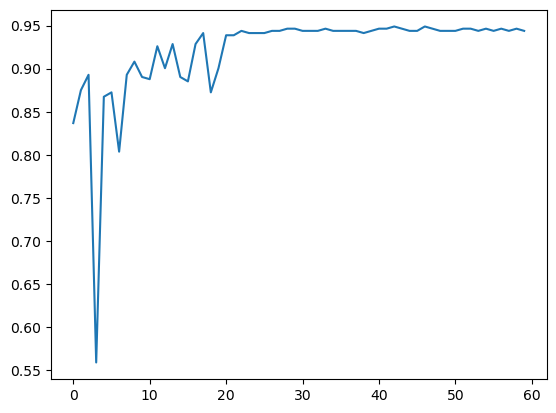

In [13]:
print(max(acc_list),np.argmax(np.array(acc_list)))
plt.plot(acc_list)

In [13]:
sent_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)
model.train(False)
preds = sent_loop(sent_dataloader, model, loss_fn)
print(len(preds))
d = {'id': np.arange(0,392), 'label': preds}
df=pd.DataFrame(data=d)
print(df)
df.to_csv('ananaspreds.csv', index=False, header=True)

C:\Users\Артур\AppData\Local\Temp\ipykernel_9768\3608014143.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)


Test Error: 
 Accuracy: 94.9%, Avg loss: 0.380796 

392
      id  label
0      0      5
1      1      5
2      2      5
3      3      5
4      4      5
..   ...    ...
387  387     33
388  388     33
389  389     33
390  390     33
391  391     33

[392 rows x 2 columns]


In [14]:
checkpoint_filename = "my_ananasmodel.pt"
torch.save(model.state_dict(), checkpoint_filename)

In [16]:
from torchvision.models import regnet_y_3_2gf, RegNet_Y_3_2GF_Weights
new_model = regnet_y_3_2gf().eval()
state_dict = torch.load("my_bestmodel.pt")
new_model.load_state_dict(state_dict)
new_model.to(device)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 72, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(72, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
            

In [17]:
sent_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)
new_model.train(False)
preds = sent_loop(sent_dataloader, new_model, loss_fn)
print(len(preds))
d = {'id': np.arange(0,392), 'label': preds}
df=pd.DataFrame(data=d)
print(df)
df.to_csv('bestananaspreds.csv', index=False, header=True)

C:\Users\Артур\AppData\Local\Temp\ipykernel_3600\3608014143.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)


Test Error: 
 Accuracy: 94.6%, Avg loss: 0.385666 

392
      id  label
0      0      5
1      1      5
2      2      5
3      3      5
4      4      5
..   ...    ...
387  387     33
388  388     33
389  389     33
390  390     33
391  391     33

[392 rows x 2 columns]
